### <center>**Audio Emotion Recognition**</center>
### <center>**Part 6 - 2D CNN implementation - 66% accuracy**</center>
###  <center>**Done By: Sandhya Palaniappan**</center>

# Introduction
We now move on to the advanced implementation part of the speaker emotion classifier series. Our goal is to develop a more sophisticated modeling approach, aiming for a significant improvement in the accuracy of the emotion classifier.

The techniques implemented above are expected not only to enhance our out-of-fold accuracy but also to improve generalization to new datasets. However, the practicality of deploying these techniques remains a separate consideration altogether... <br><br>

I will be going through all of these as part of IT1364 - Data Analysis & Visualisation:

1. Custom functions
2. MFCC without augmentation
3. MFCC with Augmentation
4. Log-melspectogram without augmentation
5. Log-melspectogram with augmentation
6. Final thoughts <br><br>

I'd like to express my gratitude to the following individuals and resources, whose work has been instrumental in shaping this audio emotion recognition series:

- **Zafarullah Mahmood**: Zafar's kernel was my starting point in learning about audio data. His contributions were pivotal in laying the foundation for my journey. You can explore Zafar's original kernels [here](https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-audio-data).

- **Mitesh Puthran**: The development of this series was inspired by Mitesh's [Speech Emotion Analyzer repository](https://github.com/MITESHPUTHRANNEU/Speech-Emotion-Analyzer). What began as a small experiment out of curiosity has evolved into a comprehensive multi-series kernel. After completing this series, I plan to contribute back to Mitesh's original GitHub repository. Thank you, Mitesh, for your foundational work.

- **Reza Chu**: The idea of data augmentation was inspired by Reza's blog post on [Speech Emotion Recognition with Convolution Neural Network](https://towardsdatascience.com/speech-emotion-recognition-with-convolution-neural-network-1e6bb7130ce3). Reza's insights into audio data augmentation expanded my knowledge in a new direction, demonstrating parallels with image data augmentation techniques. I encourage you to explore Reza's post for further insights. <br><br>

Lastly, I extend my thanks to the creators of the datasets used in this notebook. Without their valuable contributions, this project would not have been possible.

- [TESS](https://tspace.library.utoronto.ca/handle/1807/24487)
- [CREMA-D](https://github.com/CheyneyComputerScience/CREMA-D)
- [SAVEE](http://kahlan.eps.surrey.ac.uk/savee/Database.html)
- [RAVDESS](https://zenodo.org/record/1188976#.XYP8CSgzaUk)
- [RAVDESS_Kaggle](https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio) <br><br>


In [ ]:
# Keras.
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense)

# sklearn.
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other.
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob
import os
import sys
import IPython.display as ipd  # To play sound in the notebook
import warnings
# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

Using TensorFlow backend.


## 1. Custom functions
So we'll be building some custom functions to extract various features. If you've been following my series from the start, you'd be familiar with what these functions are doing. With the exception of the 2D CNN model which is new here. Further explanations ahead.

The 2D CNN takes in a 2D array of 30 MFCC bands by 216 audio length as input data. so just imagine it as a 30 x 216 pixel image. And just like in images, we could inlude a 3rd Dimension, but that's a topic for another time. It's got 4 convolution blocks of batch normalisation, max pooling and a dropout node. So your standard setup similar to VGG19, just not as deep. And we're using Adam for our optimiser.

For printing our results, i've created a class instead to encapsulate the various attributes. So that way I don't have to repeat the same code many times.

In [ ]:
'''
1. Data Augmentation method
'''
def speedNpitch(data):
    """
    Speed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

'''
2. Extracting the MFCC feature as an image (Matrix format).
'''
def prepare_data(df, n, aug, mfcc):
    X = np.empty(shape=(df.shape[0], n, 216, 1))
    input_length = sampling_rate * audio_duration

    cnt = 0
    for fname in tqdm(df.path):
        file_path = fname
        data, _ = librosa.load(file_path, sr=sampling_rate
                               ,res_type="kaiser_fast"
                               ,duration=2.5
                               ,offset=0.5
                              )

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")

        # Augmentation?
        if aug == 1:
            data = speedNpitch(data)

        # which feature?
        if mfcc == 1:
            # MFCC extraction
            MFCC = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=n_mfcc)
            MFCC = np.expand_dims(MFCC, axis=-1)
            X[cnt,] = MFCC

        else:
            # Log-melspectogram
            melspec = librosa.feature.melspectrogram(data, n_mels = n_melspec)
            logspec = librosa.amplitude_to_db(melspec)
            logspec = np.expand_dims(logspec, axis=-1)
            X[cnt,] = logspec

        cnt += 1

    return X


'''
3. Confusion matrix plot
'''
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    '''Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix.
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    '''
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



'''
# 4. Create the 2D CNN model
'''
def get_2d_conv_model(n):
    ''' Create a standard deep 2D convolutional neural network'''
    nclass = 14
    inp = Input(shape=(n,216,1))  #2D matrix of 30 MFCC bands by 216 audio length.
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)

    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)

    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)

    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = Dropout(rate=0.2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.2)(x)

    out = Dense(nclass, activation=softmax)(x)
    model = models.Model(inputs=inp, outputs=out)

    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

'''
# 5. Other functions
'''
class get_results:
    '''
    We're going to create a class (blueprint template) for generating the results based on the various model approaches.
    So instead of repeating the functions each time, we assign the results into on object with its associated variables
    depending on each combination:
        1) MFCC with no augmentation
        2) MFCC with augmentation
        3) Logmelspec with no augmentation
        4) Logmelspec with augmentation
    '''

    def __init__(self, model_history, model ,X_test, y_test, labels):
        self.model_history = model_history
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.labels = labels

    def create_plot(self, model_history):
        '''Check the logloss of both train and validation, make sure they are close and have plateau'''
        plt.plot(model_history.history['loss'])
        plt.plot(model_history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    def create_results(self, model):
        '''predict on test set and get accuracy results'''
        opt = optimizers.Adam(0.001)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        score = model.evaluate(X_test, y_test, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

    def confusion_results(self, X_test, y_test, labels, model):
        '''plot confusion matrix results'''
        preds = model.predict(X_test,
                                 batch_size=16,
                                 verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))

        classes = labels
        classes.sort()

        c = confusion_matrix(actual, preds)
        print_confusion_matrix(c, class_names = classes)

    def accuracy_results_gender(self, X_test, y_test, labels, model):
        '''Print out the accuracy score and confusion matrix heat map of the Gender classification results'''

        preds = model.predict(X_test,
                         batch_size=16,
                         verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))

        # print(accuracy_score(actual, preds))

        actual = pd.DataFrame(actual).replace({'female_angry':'female'
                   , 'female_disgust':'female'
                   , 'female_fear':'female'
                   , 'female_happy':'female'
                   , 'female_sad':'female'
                   , 'female_surprise':'female'
                   , 'female_neutral':'female'
                   , 'male_angry':'male'
                   , 'male_fear':'male'
                   , 'male_happy':'male'
                   , 'male_sad':'male'
                   , 'male_surprise':'male'
                   , 'male_neutral':'male'
                   , 'male_disgust':'male'
                  })
        preds = pd.DataFrame(preds).replace({'female_angry':'female'
               , 'female_disgust':'female'
               , 'female_fear':'female'
               , 'female_happy':'female'
               , 'female_sad':'female'
               , 'female_surprise':'female'
               , 'female_neutral':'female'
               , 'male_angry':'male'
               , 'male_fear':'male'
               , 'male_happy':'male'
               , 'male_sad':'male'
               , 'male_surprise':'male'
               , 'male_neutral':'male'
               , 'male_disgust':'male'
              })

        classes = actual.loc[:,0].unique()
        classes.sort()

        c = confusion_matrix(actual, preds)
        print(accuracy_score(actual, preds))
        print_confusion_matrix(c, class_names = classes)

In previous post you've seen the visualisation of the MFCC, where it captures all the core information of the audio file into a single image. Well, if an audio information can be interpreted as an image, then surely we can apply the same image recognition approaches like VGG19 or RESNET and the like?

The answer is yes. And is suprisingly very fast and accurate. Its not as accurate as when applying RNN type models on the audio wave itself. But its very close to its accuracy potential, and heaps faster. There's some assumptions and limitations depending on use cases of course.

Lets pick up the meta-data file again that has all our file path

In [ ]:
ref = pd.read_csv("/kaggle/input/data-path/Data_path.csv")
ref.head()

labels source                                               path
0  male_neutral  SAVEE  /kaggle/input/surrey-audiovisual-expressed-emo...
1    male_angry  SAVEE  /kaggle/input/surrey-audiovisual-expressed-emo...
2  male_neutral  SAVEE  /kaggle/input/surrey-audiovisual-expressed-emo...
3    male_angry  SAVEE  /kaggle/input/surrey-audiovisual-expressed-emo...
4  male_neutral  SAVEE  /kaggle/input/surrey-audiovisual-expressed-emo...

<a id="MFCConly"></a>
## 2. MFCC without augmentation
So, what I'm about to do is use the entire MFCC data and treat it as an image, and push it through to a 2D CNN instead of a 1D CNN that we saw in previous parts. This will be without data augmentation for now. The convergence is very quick so instead of letting it run over 50 or more epochs, I'm going to just cut it at 20.

In [ ]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc = prepare_data(ref, n = n_mfcc, aug = 0, mfcc = 1)

100%|██████████| 12162/12162 [07:00<00:00, 28.93it/s]


In [ ]:
# Split between train and test.
X_train, X_test, y_train, y_test = train_test_split(mfcc
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )


# one hot encode the target.
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process.
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Build CNN model.
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    batch_size=16, verbose = 2, epochs=20)

Train on 9121 samples, validate on 3041 samples
Epoch 1/20
 - 14s - loss: 2.2470 - acc: 0.2447 - val_loss: 1.7791 - val_acc: 0.3926
Epoch 2/20
 - 9s - loss: 1.6737 - acc: 0.4173 - val_loss: 1.5057 - val_acc: 0.4742
Epoch 3/20
 - 9s - loss: 1.4545 - acc: 0.4906 - val_loss: 1.5768 - val_acc: 0.4443
Epoch 4/20
 - 10s - loss: 1.3576 - acc: 0.5164 - val_loss: 1.2187 - val_acc: 0.5554
Epoch 5/20
 - 9s - loss: 1.2793 - acc: 0.5447 - val_loss: 1.1979 - val_acc: 0.5659
Epoch 6/20
 - 9s - loss: 1.2197 - acc: 0.5662 - val_loss: 1.1793 - val_acc: 0.5722
Epoch 7/20
 - 10s - loss: 1.1654 - acc: 0.5754 - val_loss: 1.0689 - val_acc: 0.5988
Epoch 8/20
 - 9s - loss: 1.1488 - acc: 0.5955 - val_loss: 1.0497 - val_acc: 0.6264
Epoch 9/20
 - 9s - loss: 1.1016 - acc: 0.6062 - val_loss: 1.1080 - val_acc: 0.5975
Epoch 10/20
 - 9s - loss: 1.0834 - acc: 0.6165 - val_loss: 1.0312 - val_acc: 0.6225
Epoch 11/20
 - 9s - loss: 1.0441 - acc: 0.6250 - val_loss: 1.0868 - val_acc: 0.6084
Epoch 12/20
 - 9s - loss: 1.0229 -

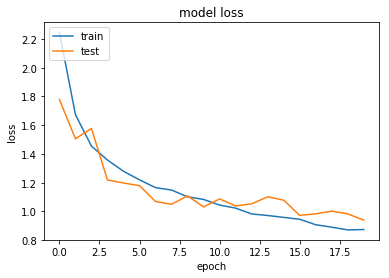

accuracy: 64.91%


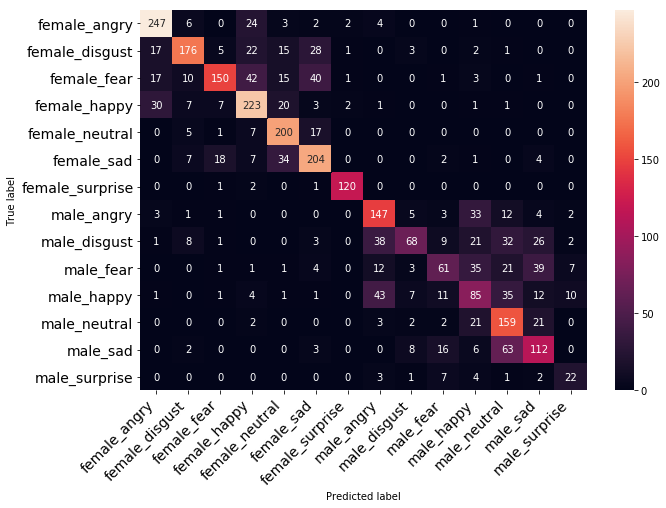

In [ ]:
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)

<a id="MFCCaug"></a>
## 3. MFCC with Augmentation
Great result with using MFCC and applying a 2D CNN on it! __64% overall accuracy__, that's a huge leap from the 48% that we saw in [Part 5](https://www.kaggle.com/ejlok1/audio-emotion-part-5-data-augmentation).

Now lets see what happens when we add in the extra step of data augmentation....

In [ ]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc_aug = prepare_data(ref, n = n_mfcc, aug = 1, mfcc = 1)

100%|██████████| 12162/12162 [06:19<00:00, 32.05it/s]


In [ ]:
# Split between train and test.
X_train, X_test, y_train, y_test = train_test_split(mfcc_aug
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# one hot encode the target.
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process.
# mean = np.mean(X_train, axis=0)
# std = np.std(X_train, axis=0)

# X_train = (X_train - mean)/std.
# X_test = (X_test - mean)/std.

# Build CNN model.
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    batch_size=16, verbose = 2, epochs=20)

Train on 9121 samples, validate on 3041 samples
Epoch 1/20
 - 11s - loss: 2.2594 - acc: 0.2443 - val_loss: 2.2442 - val_acc: 0.2453
Epoch 2/20
 - 9s - loss: 1.7849 - acc: 0.3743 - val_loss: 1.6497 - val_acc: 0.4183
Epoch 3/20
 - 9s - loss: 1.6104 - acc: 0.4280 - val_loss: 1.3855 - val_acc: 0.5140
Epoch 4/20
 - 9s - loss: 1.4908 - acc: 0.4675 - val_loss: 1.4436 - val_acc: 0.4817
Epoch 5/20
 - 9s - loss: 1.4170 - acc: 0.4960 - val_loss: 1.2816 - val_acc: 0.5258
Epoch 6/20
 - 9s - loss: 1.3560 - acc: 0.5227 - val_loss: 1.1931 - val_acc: 0.5669
Epoch 7/20
 - 10s - loss: 1.3030 - acc: 0.5397 - val_loss: 1.2722 - val_acc: 0.5436
Epoch 8/20
 - 10s - loss: 1.2727 - acc: 0.5425 - val_loss: 1.1932 - val_acc: 0.5459
Epoch 9/20
 - 9s - loss: 1.2283 - acc: 0.5639 - val_loss: 1.2007 - val_acc: 0.5748
Epoch 10/20
 - 10s - loss: 1.1936 - acc: 0.5745 - val_loss: 1.1256 - val_acc: 0.5962
Epoch 11/20
 - 10s - loss: 1.1749 - acc: 0.5783 - val_loss: 1.1937 - val_acc: 0.5469
Epoch 12/20
 - 9s - loss: 1.1543

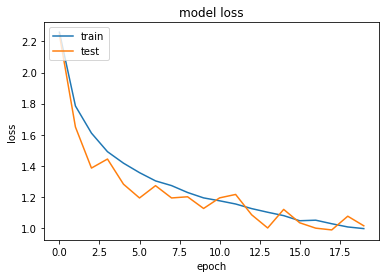

accuracy: 63.76%


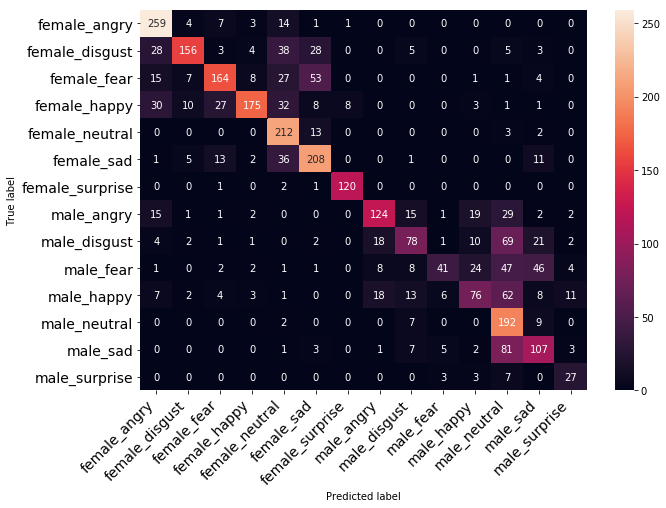

In [ ]:
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)

<a id="logmelonly"></a>
## 4. Log-melspectogram without augmentation
The accuracy is 60%, a slight drop from 64% without augmentation which is interesting and slightly unexpected. The plot of the logloss also indicates that it's converged. Suppose augmentation doesn't really do much for MFCC here... Note that due to some weird behaviour with the standardisation, I had to turn it off. So maybe that has some minor impact on the accuracy drop.

Now, we're going to look at another type of feature call log-melspectogram. I've not covered it in this series but you can check out another kernel where I covered this feature quite extensively in the **"Extracting Audio Features"** notebook. But in short, if we treat the log-melspectogram like an image just like we did with the MFCC, then we can feed it into the same 2D CNN architecture that we built! Lets give it a try, without augmentation first...

In [ ]:
sampling_rate=44100
audio_duration=2.5
n_melspec = 60
specgram = prepare_data(ref, n = n_melspec, aug = 0, mfcc = 0)

100%|██████████| 12162/12162 [05:32<00:00, 36.54it/s]


In [ ]:
# Split between train and test.
X_train, X_test, y_train, y_test = train_test_split(specgram
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )



# one hot encode the target.
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process.
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Build CNN model.
model = get_2d_conv_model(n=n_melspec)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    batch_size=16, verbose = 2, epochs=20)

Train on 9121 samples, validate on 3041 samples
Epoch 1/20
 - 13s - loss: 2.3315 - acc: 0.2020 - val_loss: 2.1621 - val_acc: 0.2815
Epoch 2/20
 - 11s - loss: 1.9285 - acc: 0.3317 - val_loss: 1.7382 - val_acc: 0.3870
Epoch 3/20
 - 12s - loss: 1.6862 - acc: 0.4089 - val_loss: 1.5748 - val_acc: 0.4476
Epoch 4/20
 - 12s - loss: 1.5521 - acc: 0.4596 - val_loss: 1.6820 - val_acc: 0.4061
Epoch 5/20
 - 11s - loss: 1.4443 - acc: 0.4858 - val_loss: 1.3010 - val_acc: 0.5354
Epoch 6/20
 - 11s - loss: 1.3748 - acc: 0.5109 - val_loss: 1.1875 - val_acc: 0.5686
Epoch 7/20
 - 11s - loss: 1.3203 - acc: 0.5372 - val_loss: 1.1704 - val_acc: 0.5735
Epoch 8/20
 - 11s - loss: 1.2798 - acc: 0.5418 - val_loss: 1.1792 - val_acc: 0.5715
Epoch 9/20
 - 11s - loss: 1.2399 - acc: 0.5547 - val_loss: 1.3239 - val_acc: 0.5373
Epoch 10/20
 - 11s - loss: 1.2030 - acc: 0.5696 - val_loss: 1.1406 - val_acc: 0.5863
Epoch 11/20
 - 11s - loss: 1.1581 - acc: 0.5844 - val_loss: 1.0761 - val_acc: 0.5991
Epoch 12/20
 - 11s - loss:

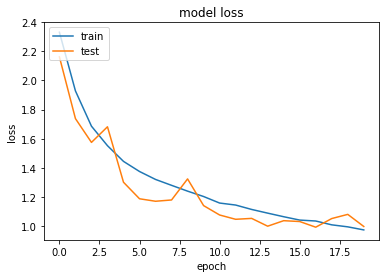

accuracy: 64.19%


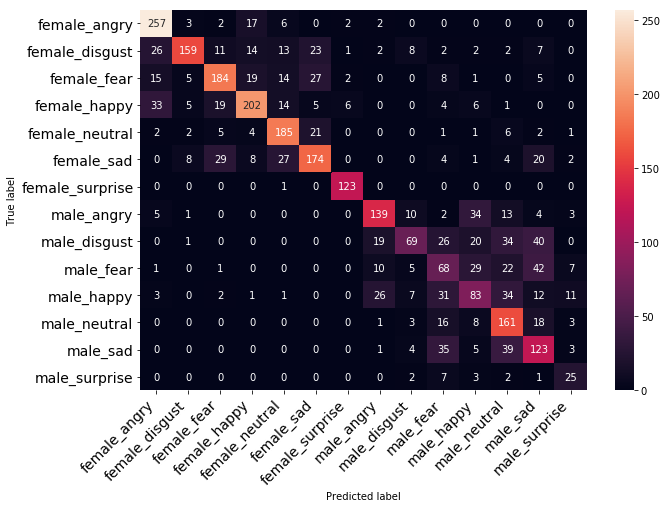

In [ ]:
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)

<a id="logmelaug"></a>
## 5. Log-melspectogram with augmentation
63% accuracy for a log-melspectogram. Slighlty lower than MFCC but very close. Notice however from the logloss plot, the log-melspectogram accuracy potential hasn't quite plateau yet. It's likely that higher number of epochs the accuracy could surpass that of the MFCC, albeit slightly. Eitherways, very interesting!

So now let's see what happens if we apply the same data augmentation here.

In [ ]:
sampling_rate=44100
audio_duration=2.5
n_melspec = 60
aug_specgram = prepare_data(ref,  n = n_melspec, aug = 1, mfcc = 0)

100%|██████████| 12162/12162 [05:59<00:00, 33.87it/s]


In [ ]:
# Split between train and test.
X_train, X_test, y_train, y_test = train_test_split(aug_specgram
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )



# one hot encode the target.
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process.
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Build CNN model.
model = get_2d_conv_model(n=n_melspec)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    batch_size=16, verbose = 2, epochs=20)

Train on 9121 samples, validate on 3041 samples
Epoch 1/20
 - 13s - loss: 2.2534 - acc: 0.2266 - val_loss: 1.9957 - val_acc: 0.3048
Epoch 2/20
 - 12s - loss: 1.8520 - acc: 0.3573 - val_loss: 1.6350 - val_acc: 0.4170
Epoch 3/20
 - 12s - loss: 1.6872 - acc: 0.4071 - val_loss: 1.5362 - val_acc: 0.4719
Epoch 4/20
 - 12s - loss: 1.5541 - acc: 0.4540 - val_loss: 1.6624 - val_acc: 0.4245
Epoch 5/20
 - 12s - loss: 1.4758 - acc: 0.4814 - val_loss: 1.3672 - val_acc: 0.5186
Epoch 6/20
 - 12s - loss: 1.3927 - acc: 0.5110 - val_loss: 1.3038 - val_acc: 0.5350
Epoch 7/20
 - 12s - loss: 1.3630 - acc: 0.5270 - val_loss: 1.2343 - val_acc: 0.5557
Epoch 8/20
 - 12s - loss: 1.3254 - acc: 0.5305 - val_loss: 1.2404 - val_acc: 0.5548
Epoch 9/20
 - 12s - loss: 1.2829 - acc: 0.5544 - val_loss: 1.1735 - val_acc: 0.5936
Epoch 10/20
 - 12s - loss: 1.2460 - acc: 0.5596 - val_loss: 1.1299 - val_acc: 0.5998
Epoch 11/20
 - 12s - loss: 1.2289 - acc: 0.5595 - val_loss: 1.1226 - val_acc: 0.6034
Epoch 12/20
 - 12s - loss:

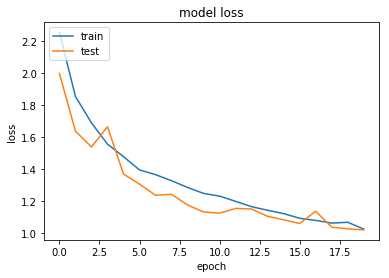

accuracy: 63.17%


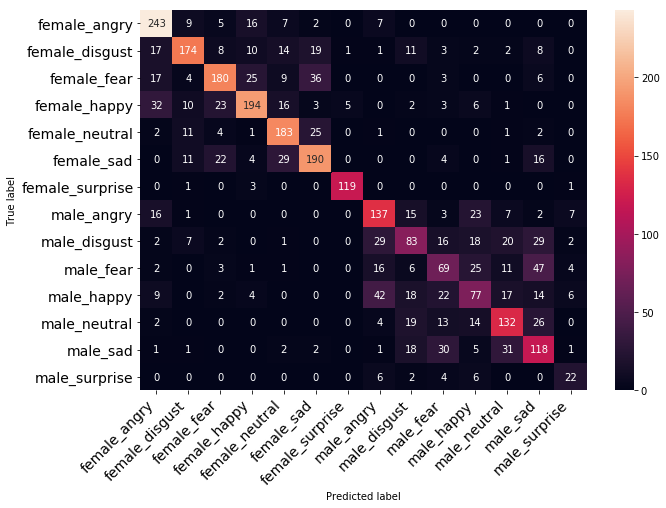

In [ ]:
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)

##### 63% accuracy as well. Not too different from wihtout doing data augmentation. Slightly dissapointed the data augmentation didn't add much value, but then again I've only implemented just 1 simple version of the augmentation. Can't conclude firmly at this point if augmentation adds any value to it.

Also, if augmentation is supposed to prevent overfitting (which is another topic on its own), then seeing a slight drop in accuracy is highly expected and welcomed.

<a id="final"></a>
## Final thoughts
Our advance implementation looks really good! All the 2D CNN models seems to do better than the 1D CNN model aproach that we took in previous parts of this series. In summary our accuracy from various approaches so far:

- 1D CNN of simple MFCC mean: Audio Emotion (Part 3 - Baseline model)  = __45%__
- 1D CNN of simple MFCC mean with data augmentation: Audio Emotion (Part 5 - Data Augmentation) = __48%__
- 2D CNN of entire MFCC without augmentation = __64%__
- 2D CNN of entire MFCC with Augmentation = __60%__
- 2D CNN of entire Log-melspectogram without augmentation = __63%__
- 2D CNN of entire Log-melspectogram with augmentation = __63%__

A large improvement to the predictive accuracy was made from using the entire MFCC and log-melspectogram information, instead of just a reduced average to fit into a 1D CNN. And because we used a 2D CNN, we could take advantage of the entire information presented through the MFCC and mel-spectogram

Notice that whilst the model isn't perfect at classifying the different emotions, its done pretty well at distinguishing the genders!

0.9539625123314699


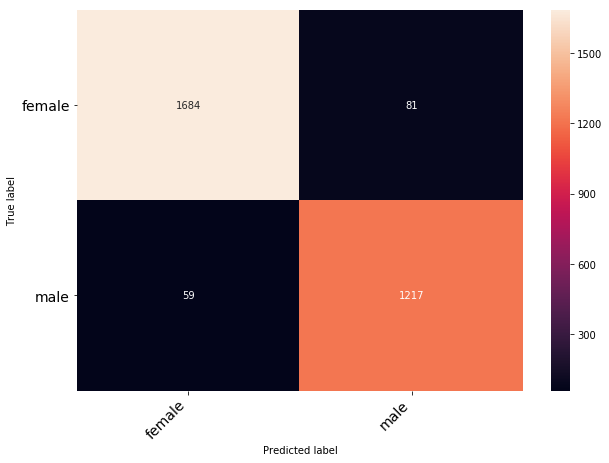

In [ ]:
results.accuracy_results_gender(X_test, y_test, ref.labels.unique(), model)

 They are a few other ideas that I have stashed them for now but if anyone's keen to try it out themselves, then here's what else you can look at:
- Try a few other datasets (eg. EmoDB)
- Trim white noise (silence)
- Apply the other data augmentation methods.
- Transfer learning from popular Image Recognition benchmarks - ResNet50 or XCEPTION or VGG19 for simplicity.